# Objective

Obtain 3 dataframes of price (`price_pivot`), freight (`freight_pivot`) and orders (`orders_pivot`) for each gtin along the timestamps within a date range, considering a given frequency (hours, days, weeks, etc).

### Importing packages

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### Dataframe with complete range

Let's start by creating a dataframe with every data point we want to measure. It will contain hourly intervals, equally spaced between two dates.  
You can change the parameters in the cell below:

In [2]:
freq = 'H' # 'H' is for hourly data. You can use 'D' for days, 'W' for last day of week, 'Q' for quarter, etc.

start_date = '1/1/2018' # MM/DD/YYYY
end_date = '4/1/2020' # MM/DD/YYYY

In [3]:
df = pd.DataFrame(data=pd.date_range(start='1/1/2018', end='4/1/2020', freq=freq),
                  columns=['date'])

df.head(2)

,date
0,2018-01-01 00:00:00
1,2018-01-01 01:00:00


In [4]:
df.tail(2)

,date
19703,2020-03-31 23:00:00
19704,2020-04-01 00:00:00


### Orders dataset

In [5]:
# READING ORDERS DATA AND TRANSFORMING COLUMNS
orders = pd.read_csv('data/orders.csv', dtype={'product_gtin':'str','origin_zip':'str',
                                               'destination_zip':'str'})

orders['purchase_timestamp'] = pd.to_datetime(orders['purchase_timestamp'])

In [6]:
orders.head()

,purchase_timestamp,seller_id,product_gtin,product_sku,channel_slug,channel_store,price,freight_value,price_freight_shift,commission_product_olist,commission_freight_olist,origin_zip,origin_state,origin_city,destination_zip,destination_state,destination_city
0,2019-07-20 11:19:43,a97001a2-a7d2-4bd6-b0d5-1da2a2b8abd9,6952202281890,PRDWRHUYLLMFX2U0,mercadolivre,mercadolivre,82.99,20.86,0.0,0.20,0.20,01109010,SP,SAO PAULO,89265575,SC,Jaraguá do Sul
1,2019-11-11 20:43:23,a97001a2-a7d2-4bd6-b0d5-1da2a2b8abd9,6951003643197,PRDACYVT895VMO7H,mercadolivre,mercadolivre,119.90,0.00,0.0,0.20,0.20,01109010,SP,SAO PAULO,06040470,SP,Osasco
2,2020-03-01 16:25:00,c58b83e5-52de-43fe-8399-a7bc312e2aa5,7898907175302,PRDKTDU50G9FVV57,cnova,ex,39.90,14.24,0.0,0.19,0.19,20910970,RJ,RIO DE JANEIRO,22260210,RJ,Rio de Janeiro
3,2020-02-04 12:04:10,a97001a2-a7d2-4bd6-b0d5-1da2a2b8abd9,6951003643197,PRDACYVT895VMO7H,mercadolivre,mercadolivre,130.95,0.00,0.0,0.20,0.20,01109010,SP,SAO PAULO,89062100,SC,Blumenau
4,2018-12-14 13:52:19,a97001a2-a7d2-4bd6-b0d5-1da2a2b8abd9,6951003643197,PRDACYVT895VMO7H,mercadolivre,mercadolivre,128.99,21.51,0.0,0.20,0.20,01109010,SP,SAO PAULO,66055000,PA,Belém


In [7]:
orders.product_gtin.nunique()

647

In [8]:
# FILTERING ORDERS DATASET

filter_orders = orders[['purchase_timestamp','product_gtin',
                        'price','freight_value',
                        'commission_product_olist','commission_freight_olist']].copy()

# ADD ARTIFICIAL COLUMN WITH THE NUMBER OF ORDERS -> WILL BE USED TO COUNT THE ORDERS BY HOUR
filter_orders['orders'] = 1


# GROUPS ORDERS BY CHOSEN FREQUENCY
filter_orders = filter_orders.groupby([pd.Grouper(key='purchase_timestamp', freq=freq),'product_gtin'])\
                  .agg({'price':'mean', 
                        'freight_value':'mean',
                        'commission_product_olist':'mean',
                        'commission_freight_olist':'mean',
                        'orders':'sum'}).reset_index()

# FILTER DATES IN SPECIFIED DATE RANGE
filter_orders = filter_orders[(filter_orders['purchase_timestamp'] > df['date'].iloc[0]) & (filter_orders['purchase_timestamp'] < df['date'].iloc[-1])].reset_index()

In [9]:
filter_orders.head()

,index,purchase_timestamp,product_gtin,price,freight_value,commission_product_olist,commission_freight_olist,orders
0,1250,2018-01-01 10:00:00,7895099385786,59.90,15.17,0.2,0.2,1
1,1251,2018-01-01 13:00:00,7909389621864,239.99,45.00,0.2,0.2,1
2,1252,2018-01-01 14:00:00,7909389695100,39.90,29.39,0.2,0.2,1
3,1253,2018-01-01 18:00:00,7909389621864,239.99,51.55,0.2,0.2,1
4,1254,2018-01-02 09:00:00,6951003643197,239.99,16.44,0.2,0.2,2


In [10]:
# PIVOT TABLE FOR PRICE ALONG DATES FOR EACH GTIN

price_pivot = filter_orders.pivot_table(index='product_gtin', columns='purchase_timestamp', values='price')
price_pivot

purchase_timestamp,2018-01-01 10:00:00,2018-01-01 13:00:00,2018-01-01 14:00:00,2018-01-01 18:00:00,2018-01-02 09:00:00,2018-01-02 11:00:00,2018-01-02 13:00:00,2018-01-02 14:00:00,2018-01-02 18:00:00,2018-01-02 21:00:00,...,2020-03-12 16:00:00,2020-03-12 17:00:00,2020-03-12 19:00:00,2020-03-12 20:00:00,2020-03-12 21:00:00,2020-03-12 22:00:00,2020-03-12 23:00:00,2020-03-13 00:00:00,2020-03-13 05:00:00,2020-03-13 07:00:00
product_gtin,,,,,,,,,,,,,,,,,,,,,
1001001118649,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1003001113372,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1003001209488,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1234567896618,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1286508320126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9788516100155,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9788531116438,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9788551002049,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# CALCULATE MISSING TIMESTAMP COLUMNS
missing_dates_columns = set(df['date']) - set(price_pivot.columns)
sorted(missing_dates_columns)

[Timestamp('2018-01-01 00:00:00'),
 Timestamp('2018-01-01 01:00:00'),
 Timestamp('2018-01-01 02:00:00'),
 Timestamp('2018-01-01 03:00:00'),
 Timestamp('2018-01-01 04:00:00'),
 Timestamp('2018-01-01 05:00:00'),
 Timestamp('2018-01-01 06:00:00'),
 Timestamp('2018-01-01 07:00:00'),
 Timestamp('2018-01-01 08:00:00'),
 Timestamp('2018-01-01 09:00:00'),
 Timestamp('2018-01-01 11:00:00'),
 Timestamp('2018-01-01 12:00:00'),
 Timestamp('2018-01-01 15:00:00'),
 Timestamp('2018-01-01 16:00:00'),
 Timestamp('2018-01-01 17:00:00'),
 Timestamp('2018-01-01 19:00:00'),
 Timestamp('2018-01-01 20:00:00'),
 Timestamp('2018-01-01 21:00:00'),
 Timestamp('2018-01-01 22:00:00'),
 Timestamp('2018-01-01 23:00:00'),
 Timestamp('2018-01-02 00:00:00'),
 Timestamp('2018-01-02 01:00:00'),
 Timestamp('2018-01-02 02:00:00'),
 Timestamp('2018-01-02 03:00:00'),
 Timestamp('2018-01-02 04:00:00'),
 Timestamp('2018-01-02 05:00:00'),
 Timestamp('2018-01-02 06:00:00'),
 Timestamp('2018-01-02 07:00:00'),
 Timestamp('2018-01-

In [12]:
# BLANK DATAFRAME WITH EXTRA COLUMNS
price_pivot_extra_columns = pd.DataFrame(index=price_pivot.index, columns=missing_dates_columns)

In [13]:
# CONCATENATE BLANK COLUMNS AND SORT THEM
price_pivot = pd.concat([price_pivot, price_pivot_extra_columns], axis=1)
price_pivot = price_pivot.reindex(sorted(price_pivot.columns), axis=1)
price_pivot.columns

DatetimeIndex(['2018-01-01 00:00:00', '2018-01-01 01:00:00',
               '2018-01-01 02:00:00', '2018-01-01 03:00:00',
               '2018-01-01 04:00:00', '2018-01-01 05:00:00',
               '2018-01-01 06:00:00', '2018-01-01 07:00:00',
               '2018-01-01 08:00:00', '2018-01-01 09:00:00',
               ...
               '2020-03-31 15:00:00', '2020-03-31 16:00:00',
               '2020-03-31 17:00:00', '2020-03-31 18:00:00',
               '2020-03-31 19:00:00', '2020-03-31 20:00:00',
               '2020-03-31 21:00:00', '2020-03-31 22:00:00',
               '2020-03-31 23:00:00', '2020-04-01 00:00:00'],
              dtype='datetime64[ns]', length=19705, freq=None)

In [14]:
price_pivot

,2018-01-01 00:00:00,2018-01-01 01:00:00,2018-01-01 02:00:00,2018-01-01 03:00:00,2018-01-01 04:00:00,2018-01-01 05:00:00,2018-01-01 06:00:00,2018-01-01 07:00:00,2018-01-01 08:00:00,2018-01-01 09:00:00,...,2020-03-31 15:00:00,2020-03-31 16:00:00,2020-03-31 17:00:00,2020-03-31 18:00:00,2020-03-31 19:00:00,2020-03-31 20:00:00,2020-03-31 21:00:00,2020-03-31 22:00:00,2020-03-31 23:00:00,2020-04-01 00:00:00
product_gtin,,,,,,,,,,,,,,,,,,,,,
1001001118649,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1003001113372,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1003001209488,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1234567896618,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1286508320126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9788516100155,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9788531116438,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9788551002049,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


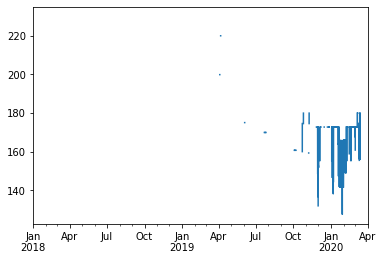

In [15]:
gtin = '7908243600137'
price_pivot.loc[gtin].plot()

In [16]:
# SAME FOR FREIGHT VALUE

freight_pivot = filter_orders.pivot_table(index='product_gtin', columns='purchase_timestamp', values='freight_value')
missing_dates_columns = set(df['date']) - set(freight_pivot.columns)
freight_pivot_extra_columns = pd.DataFrame(index=freight_pivot.index, columns=missing_dates_columns)
freight_pivot = pd.concat([freight_pivot, freight_pivot_extra_columns], axis=1)
freight_pivot = freight_pivot.reindex(sorted(freight_pivot.columns), axis=1)

In [17]:
freight_pivot

,2018-01-01 00:00:00,2018-01-01 01:00:00,2018-01-01 02:00:00,2018-01-01 03:00:00,2018-01-01 04:00:00,2018-01-01 05:00:00,2018-01-01 06:00:00,2018-01-01 07:00:00,2018-01-01 08:00:00,2018-01-01 09:00:00,...,2020-03-31 15:00:00,2020-03-31 16:00:00,2020-03-31 17:00:00,2020-03-31 18:00:00,2020-03-31 19:00:00,2020-03-31 20:00:00,2020-03-31 21:00:00,2020-03-31 22:00:00,2020-03-31 23:00:00,2020-04-01 00:00:00
product_gtin,,,,,,,,,,,,,,,,,,,,,
1001001118649,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1003001113372,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1003001209488,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1234567896618,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1286508320126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9788516100155,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9788531116438,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9788551002049,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


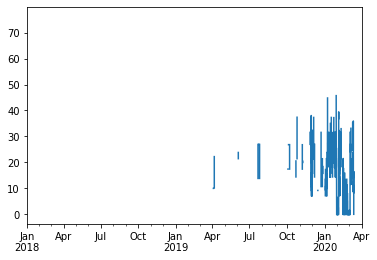

In [18]:
gtin = '7908243600137'
freight_pivot.loc[gtin].plot()

In [19]:
# SAME FOR ORDERS

orders_pivot = filter_orders.pivot_table(index='product_gtin', columns='purchase_timestamp', values='orders')
missing_dates_columns = set(df['date']) - set(orders_pivot.columns)
orders_pivot_extra_columns = pd.DataFrame(index=orders_pivot.index, columns=missing_dates_columns)
orders_pivot = pd.concat([orders_pivot, orders_pivot_extra_columns], axis=1)
orders_pivot = orders_pivot.reindex(sorted(orders_pivot.columns), axis=1)

In [20]:
orders_pivot

,2018-01-01 00:00:00,2018-01-01 01:00:00,2018-01-01 02:00:00,2018-01-01 03:00:00,2018-01-01 04:00:00,2018-01-01 05:00:00,2018-01-01 06:00:00,2018-01-01 07:00:00,2018-01-01 08:00:00,2018-01-01 09:00:00,...,2020-03-31 15:00:00,2020-03-31 16:00:00,2020-03-31 17:00:00,2020-03-31 18:00:00,2020-03-31 19:00:00,2020-03-31 20:00:00,2020-03-31 21:00:00,2020-03-31 22:00:00,2020-03-31 23:00:00,2020-04-01 00:00:00
product_gtin,,,,,,,,,,,,,,,,,,,,,
1001001118649,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1003001113372,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1003001209488,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1234567896618,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1286508320126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9788516100155,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9788531116438,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9788551002049,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


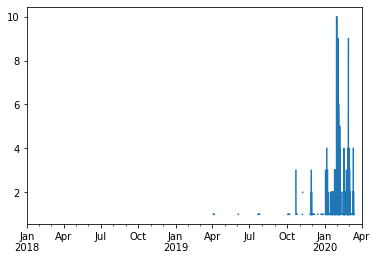

In [21]:
gtin = '7908243600137'
orders_pivot.loc[gtin].plot()